# Factorization Machine

1. Paper
  - [논문](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
  - [Higher-Order Factorization Machines](https://papers.nips.cc/paper/2016/file/158fc2ddd52ec2cf54d3c161f2dd6517-Paper.pdf)
2. Reference: Open-source
  - [libfm](http://libfm.org), [libfm-github](https://github.com/srendle/libfm)
  - [PyTorchFM](https://github.com/rixwew/pytorch-fm)
  - [fastFM](https://github.com/ibayer/fastFM)
  - [xlearn](https://github.com/aksnzhy/xlearn)

#Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/My Drive/data/kmrd"
%cd $data_path

if not os.path.exists(data_path):
  !git clone https://github.com/lovit/kmrd
  !python setup.py install
else:
  print("data and path already exists!")

/content/drive/My Drive/data/kmrd
data and path already exists!


In [21]:
path = data_path + '/kmr_dataset/datafile/kmrd-small'

##Data Loader

- KMRD

### rates.csv 데이터를 train과 valid로 나누기

In [22]:
df = pd.read_csv(os.path.join(path,'rates.csv'))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

### movie dataframe 으로 정보 종합하기

In [23]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

print(movies_df.shape)
print(movies_df.head())

(999, 7)
                      title  ...   country
movie                        ...          
10001                시네마 천국  ...  이탈리아,프랑스
10002              빽 투 더 퓨쳐  ...        미국
10003            빽 투 더 퓨쳐 2  ...        미국
10004            빽 투 더 퓨쳐 3  ...        미국
10005  스타워즈 에피소드 4 - 새로운 희망  ...        미국

[5 rows x 7 columns]


In [7]:
movies_df.columns

Index(['title', 'title_eng', 'year', 'grade', 'genres', 'people', 'country'], dtype='object')

### Genres sparse vector 만들기

In [24]:
movies_df['genres'].head()

movie
10001       드라마/멜로/로맨스
10002           SF/코미디
10003           SF/코미디
10004    서부/SF/판타지/코미디
10005     판타지/모험/SF/액션
Name: genres, dtype: object

In [25]:
dummy_genres_df = movies_df['genres'].str.get_dummies(sep='/')
dummy_genres_df.head()

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
movie,,,,,,,,,,,,,,,,,,,,,
10001,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10004,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
10005,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


### Grade sparse vector 만들기

In [26]:
movies_df['grade'].unique()

array(['전체 관람가', '12세 관람가', 'PG', '15세 관람가', 'NR', '청소년 관람불가', 'PG-13',
       'R', 'G', nan], dtype=object)

In [27]:
dummy_grade_df = pd.get_dummies(movies_df['grade'], prefix='grade')
dummy_grade_df.head()

,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가
movie,,,,,,,,,
10001,0,0,0,0,0,0,0,1,0
10002,1,0,0,0,0,0,0,0,0
10003,1,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,1,0
10005,0,0,0,0,1,0,0,0,0


## Factorization Machine format 으로 바꾸기

- user 를 one-hot vector 로 나타낸다
- item 을 one-hot vector 로 나타낸다
- movies_df 에서 categorical features 를 만든다

In [28]:
train_df.head()
# (user, movie, rate) -> 2D rating matrix -> matrix factorization, user-based, item-based CF

,user,movie,rate,time
137023,48423,10764,10,1212241560
92868,17307,10170,10,1122185220
94390,18180,10048,10,1573403460
22289,1498,10001,9,1432684500
80155,12541,10022,10,1370458140


In [29]:
train_df = train_df[:1000]
print(train_df.shape)

(1000, 4)


In [30]:
# user, item one-hot vector에 추가로 붙여줄 genres 데이터 포맷 생성 방식
train_df['movie'].apply(lambda x: dummy_genres_df.loc[x])

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
137023,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
92868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
94390,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22289,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
80155,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
120892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
93371,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [31]:
# user one-hot vector 만드는 방법
user_check = pd.get_dummies(train_df['user'], prefix='user')
user_check.head()

,user_0,user_3,user_4,user_8,user_19,user_25,user_28,user_29,user_41,user_42,user_44,user_45,user_58,user_65,user_67,user_70,user_73,user_79,user_82,user_86,user_94,user_95,user_98,user_107,user_110,user_127,user_130,user_136,user_140,user_161,user_176,user_179,user_181,user_182,user_213,user_214,user_217,user_222,user_224,user_261,...,user_47075,user_47275,user_47421,user_47486,user_47493,user_47547,user_47746,user_47823,user_47847,user_47971,user_48256,user_48333,user_48387,user_48423,user_48432,user_48475,user_48521,user_48761,user_48802,user_48846,user_48864,user_49037,user_49045,user_49540,user_49606,user_49645,user_49686,user_49692,user_49976,user_50323,user_50358,user_50470,user_50617,user_50924,user_51129,user_51236,user_51293,user_51344,user_51940,user_51993
137023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# movie one-hot vector 만드는 방법
movie_check = pd.get_dummies(train_df['movie'], prefix='movie')
print(movie_check.head())

        movie_10001  movie_10002  ...  movie_10988  movie_10998
137023            0            0  ...            0            0
92868             0            0  ...            0            0
94390             0            0  ...            0            0
22289             1            0  ...            0            0
80155             0            0  ...            0            0

[5 rows x 263 columns]


In [33]:
X_train = pd.concat([pd.get_dummies(train_df['user'], prefix='user'),
           pd.get_dummies(train_df['movie'], prefix='movie'),
           train_df['movie'].apply(lambda x: dummy_genres_df.loc[x]),
           train_df['movie'].apply(lambda x: dummy_grade_df.loc[x])], axis=1)

In [34]:
X_train.shape

(1000, 1217)

In [19]:
# 평균 평점이 높기 때문에 10만 1로 주고, 나머지는 -1로 binary 지정한다
# loss 계산을 0이 아닌 -1로 지정한다
y_train = train_df['rate'].apply(lambda x: 1 if x > 9 else -1)
print(X_train.shape)
print(y_train.shape)

# 0이 아닌 데이터 위치 확인하기위해 csr matrix 활용한다
# csr_matrix 설명 참고: https://rfriend.tistory.com/551
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

(1000, 1217)
(1000,)


In [35]:
X_train_sparse

<1000x1217 sparse matrix of type '<class 'numpy.longlong'>'
	with 5614 stored elements in Compressed Sparse Row format>

## Factorization Machine 훈련하기

1. Model Equation

  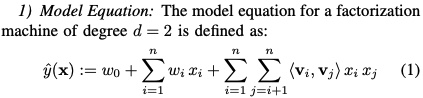

2. Pairwise Interaction to be computed
  - Linear Complexity
  
  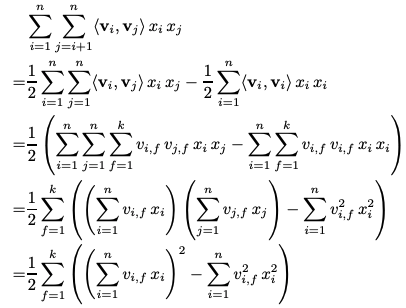

In [37]:
# prediction과 label 간 negative log likelihood 구하기
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)

In [38]:
# gradients 업데이트하기
def sgd(X, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)
        
        # loss and its gradient 구하기
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # bias/intercept term 업데이트하기
        w0 -= learning_rate * loss_gradient

        # weight 업데이트하기
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # factor 업데이트하기
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss

In [39]:
def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])

    # gradient update할 때, summed는 독립이므로 re-use 가능
    return pred, summed

In [40]:
# Train Factorization Machine
# X -> sparse csr_matrix, y -> label
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features) # -> w
    global_bias = 0.0 # -> w0
    
    # latent factors for all features -> v
    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples, num_features,
                            global_bias, weights,
                            feature_factors, num_factors,
                            learning_rate, reg_weights, reg_features)
        print(f'[epoch: {epoch+1}], loss: {loss}')

        epoch_loss.append(loss)
      
    return epoch_loss

In [41]:
config = {
    "num_epochs": 10,
    "num_factors": 10,
    "learning_rate": 0.1,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [42]:
epoch_loss = fit(X_train_sparse, y_train.values, config)

[epoch: 1], loss: 2.8950685810331
[epoch: 2], loss: 1.0539279672693282
[epoch: 3], loss: 0.48798286943144087
[epoch: 4], loss: 0.2542031670435284
[epoch: 5], loss: 0.16547949261160352
[epoch: 6], loss: 0.10758227275229511
[epoch: 7], loss: 0.08486575011509657
[epoch: 8], loss: 0.06950433432744635
[epoch: 9], loss: 0.058610141541097734
[epoch: 10], loss: 0.05029967491264804


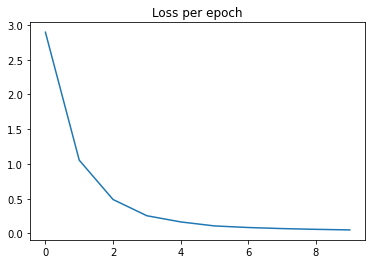

In [43]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()